## Drone Detection

In [88]:
# essential imports
import os
import csv
import cv2
import json
import numpy as np

# plotting and display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, clear_output

# YOLO model from ultralytics package
from ultralytics import YOLO

# custom utilities
from utils import *

# reflect changes in src code immediately w/o restarting kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Set device and load model

In [57]:
# set the device depending on available GPU
device = set_device()

Using device: mps:0


In [59]:
# choose model size: n for nano, s for small, m for medium, l for large, x for extra large
model_size = 'm'  

# load pretrained YOLOv8 model
model = YOLO(f"yolov8{model_size}.pt")

#### Select dataset and video

Frame size: 1920 x 1080


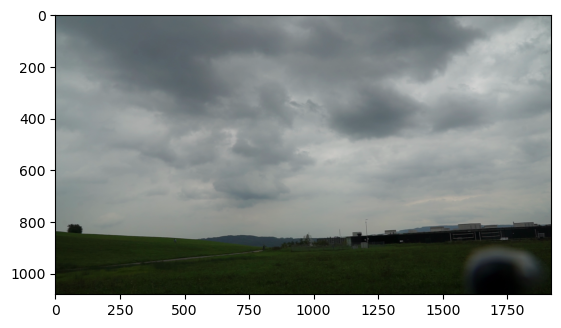

In [19]:
# all datasets path
data_path = './data/drone-tracking-datasets/'

# select dataset and camera
dataset_num = 3
cam_num = 4
video_path = os.path.join(data_path, f'dataset{dataset_num}/cam{cam_num}.mp4')

# get sample frame and store width and height
cap = cv2.VideoCapture(video_path)
ret, sample_frame = cap.read()
cap.release()
sample_frame_rgb = cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB)
frame_height, frame_width, _ = sample_frame.shape
print(f"Frame size: {frame_width} x {frame_height}")
plt.imshow(sample_frame_rgb)

#### Run detection with YOLO

In [ ]:
# select tracker
tracker = "sort.yaml"  # or 'bytetrack.yaml', 'strongsort.yaml'

# pick either show or stream

# run detection on video
results = model.predict(
    source=video_path, 
    device=device,
    tracker=tracker,

    #show=True, # display live output in external window (do not return generator)
    save=True,  # save output video with bounding boxes to runs/detect/
    stream=True  # return a generator that yields results for each frame, doesn't store whole video in memory
)

In [62]:
# haven't finetuned YOLO yet for drone detection class 
# in the meantime, model identifies drones as either airplanes, birds, kites
print(model.names[4])
print(model.names[14])
print(model.names[33])

airplane
bird
kite


In [ ]:
# only keep detections of target classes (airplane, bird, kite in that order)
target_classes = torch.tensor([4, 14, 33], device=device, dtype=torch.float32)

# save trajectory to CSV
csv_file = f"trajectory_dataset{dataset_num}_cam{cam_num}.csv"

trajectory = []  # list to store (frame_id, x_center, y_center)

for frame_id, result in enumerate(results, start=1):

    # filter boxes to only target classes
    mask = torch.isin(result.boxes.cls, target_classes)
    target_boxes = result.boxes[mask]
    
    if len(target_boxes) > 0:
        # Choose the most confident detection among these classes
        best_idx = target_boxes.conf.argmax()
        box = target_boxes[best_idx].xywh[0]
        x_center, y_center = box[0].item(), box[1].item()
    else:
        x_center, y_center = float('nan'), float('nan')

    trajectory.append([frame_id, x_center, y_center])

# save to CSV
with open(csv_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["frame_id", "x_center", "y_center"])
    writer.writerows(trajectory)

print(f"Trajectory saved to {csv_file}")

#### Plot 2D trajectory

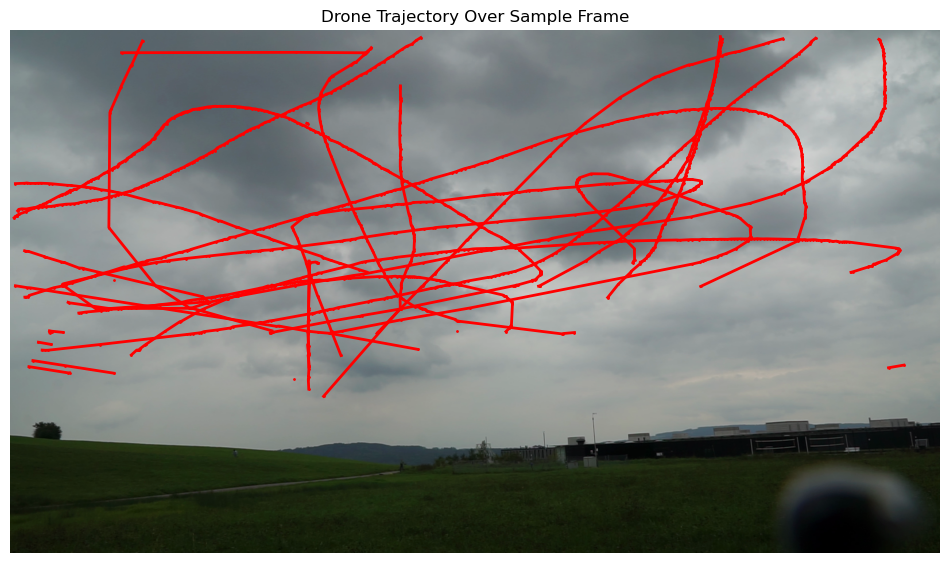

In [84]:
plot_2d_trajectory(trajectory, sample_frame_rgb)

#### Plot GT 3D trajectory

In [86]:
# load text file
data_path = './data/drone-tracking-datasets/'
dataset_num = 3
trajectory_path = os.path.join(data_path, f'dataset{dataset_num}/trajectory/rtk.txt')

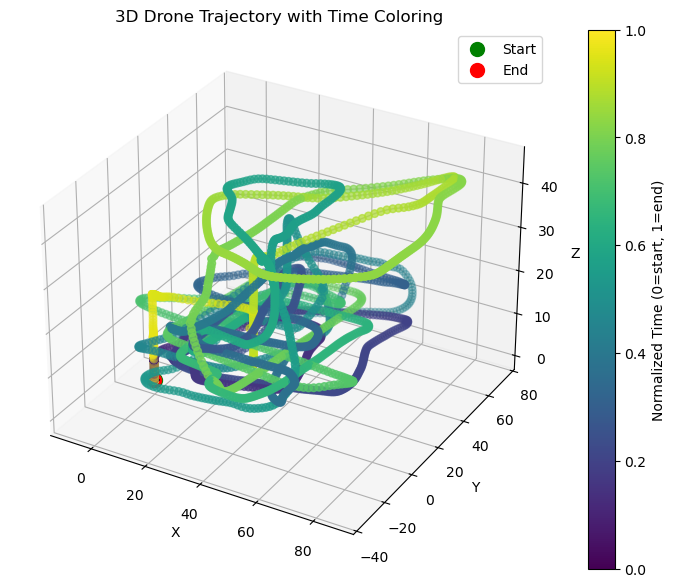

In [ ]:
plot_3d_trajectory_static(trajectory_path)

In [ ]:
plot_3d_trajectory_interactive(trajectory_path)

#### Depth Estimation

In [ ]:
# first i need to pick a reference camera for synchronization
# then i can align the frames from other cameras (maybe start with one)

# then when i have aligned frames that detect the xy coords of the drone at the same time
# i can triangulate the 3d position
# use the intrinsics (K and distortion params), and known camera positions to do this 

In [ ]:
# run the detection on all videos and save to file
data_path = './data/drone-tracking-datasets/'
dataset_num = 3
num_cams = 6

# select tracker
tracker = "sort.yaml"  # or 'bytetrack.yaml', 'strongsort.yaml'

for cam_num in range(num_cams):
    video_path = os.path.join(data_path, f'dataset{dataset_num}/cam{cam_num}.mp4')
    csv_file = os.path.join('dataset3_result_detections', f'detections_cam{cam_num}.txt')

    results = model.predict(source=video_path, tracker=tracker, save=False, stream=True)

    trajectory = []  # list to store (frame_id, x_center, y_center)

    for frame_id, result in enumerate(results, start=1):
        if len(result.boxes) > 0:
            # Take first detection (assuming single drone)
            box = result.boxes[0].xywh[0]  # [x_center, y_center, width, height] in pixels
            x_center, y_center = box[0].item(), box[1].item()
        else:
            # If no detection, log 0
            x_center, y_center = 0.0, 0.0

        trajectory.append([frame_id, x_center, y_center])

    # save to CSV
    with open(csv_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["frame_id", "x_center", "y_center"])
        writer.writerows(trajectory)

    print(f"Trajectory saved to {csv_file}")

In [93]:
# get data 
data = np.genfromtxt("trajectory.csv", delimiter=",", skip_header=1) # skip_header = true if CSV has header

print(len(data))
print(data[35,1])

5334
519.1287231445312


In [ ]:
# info for dataset 3 and cams

'''
cam0 - gopro3
cam1 - mate7
cam2 - mate10
cam3 - sony5n_1440x1080
cam4 - sony5100
cam5 - sonyG
'''

# locations
'''
44.535 11.56253333 -1.1467
4.3962 -54.27346667 4.0965
-42.5242 -21.00086667 -1.7639
40.1912 44.79053333 -0.9379
-34.8458 -44.00906667 1.4179
-11.7524 62.93033333 -1.6659
'''

In [ ]:
# sync params for time shift and scale

# Time scale (alpha) matrix
alpha = np.array([
    [1.0000, 0.5005, 0.4960, 0.4171, 0.5000, 0.8341],
    [1.9982, 1.0000, 0.9910, 0.8333, 0.9990, 1.6667],
    [2.0163, 1.0091, 1.0000, 0.8409, 1.0081, 1.6819],
    [2.3978, 1.2000, 1.1892, 1.0000, 1.1988, 2.0000],
    [2.0001, 1.0010, 0.9919, 0.8342, 1.0000, 1.6683],
    [1.1989, 0.6000, 0.5946, 0.5000, 0.5994, 1.0000],
])

# Time shift (beta) matrix
beta = np.array([
    [0.00,     1013.95,  546.98,  251.16,  961.02,  137.51],
    [-2026.04,    0.00, -457.83, -593.82,  -51.96, -1552.47],
    [-1102.90,  461.99,    0.00, -208.81,  409.59,  -782.45],
    [ -602.21,  712.57,  248.32,    0.00,  659.93,  -364.81],
    [-1922.12,   52.01, -406.29, -551.00,    0.00, -1465.78],
    [ -164.85,  931.45,  465.22,  182.40,  878.60,     0.00],
])

# decide ref cam
ref_cam_num = 0

# isolate relevant rows for both matrics
alpha_ref = alpha[ref_cam_num, :]
beta_ref = beta[ref_cam_num, :]

print(alpha_ref)
print(beta_ref) 

In [94]:
# get the intrinsics for the cameras from json files

camera = 'gopro3'
json_file = os.path.join(data_path, f'calibration/{camera}/{camera}.json')

# Load JSON
with open(json_file, "r") as f:
    cam_info = json.load(f)

# Access attributes
K = cam_info["K-matrix"]
dist = cam_info["distCoeff"]
fps = cam_info["fps"]
res = cam_info["resolution"]

print("K matrix:", K)
print("Distortion coeffs:", dist)
print("FPS:", fps)
print("Resolution:", res)

K matrix: [[874.4721846047786, 0.0, 970.2688358898922], [0.0, 894.1080937815644, 531.2757796052425], [0.0, 0.0, 1.0]]
Distortion coeffs: [-0.260720634999793, 0.07494782427852716, -0.00013631462898833923, 0.00017484761775924765, -0.00906247784302948]
FPS: 59.94006
Resolution: [1920, 1080]


In [ ]:
# If CSV has header
data_1 = np.genfromtxt("trajectory.csv", delimiter=",", skip_header=1)
data_2 = np.genfromtxt("trajectory_1.csv", delimiter=",", skip_header=1)

# chose second camera
cam_num_2 = 1
# get sync params
alpha_2 = alpha_ref[cam_num_2]
beta_2 = beta_ref[cam_num_2]


# iterate through frames of reference camera
for frame_id in range(len(data)):

    # use sync info to get corresponding frame id from other camera
    j = alpha_2 * frame_id + beta_2
    if j < 0 or j >= len(data_2):
        continue  # skip if out of bounds

    # get x, y coords from both cameras
    x1, y1 = data_1[frame_id, 1], data_1[frame_id, 2]
    x2, y2 = data_2[int(j), 1], data_2[int(j), 2]

    # undistort points using cv2 method
    ray1 = cv2.undistortPoints(np.array([[[x1, y1]]], dtype=np.float32), K1, dist1, P=K1)
    ray2 = cv2.undistortPoints(np.array([[[x2, y2]]], dtype=np.float32), K2, dist2, P=K2)

    # transform rays to world coordinates
    

    # triangulate 3d point from rays


In [ ]:
# try to match the points in two overlapping frames

data_path = './data/drone-tracking-datasets/'

def get_first_frame(video_path):

    cap = cv2.VideoCapture(video_path)
    ret, sample_frame = cap.read()
    cap.release()
    sample_frame_rgb = cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB)
    #plt.imshow(sample_frame_rgb)
    #plt.show()

    return sample_frame_rgb


video_path = os.path.join(data_path, f'dataset3/cam1.mp4')
cam1_frame = get_first_frame(video_path)

video_path = os.path.join(data_path, f'dataset3/cam2.mp4')
cam2_frame = get_first_frame(video_path)

In [13]:
print(cam1_frame.shape)
print(cam2_frame.shape)

(1080, 1920, 3)
(2160, 3840, 3)


In [ ]:
# back to the fundamentals

# matched points in pixel coordinates
pts1 = np.array([...], dtype=np.float32)  # Nx2
pts2 = np.array([...], dtype=np.float32)  # Nx2

# camera intrinsics
K1 = np.array([[fx1, 0, cx1],
               [0, fy1, cy1],
               [0,   0,   1]], dtype=np.float64)
K2 = np.array([[fx2, 0, cx2],
               [0, fy2, cy2],
               [0,   0,   1]], dtype=np.float64)

# normalize points
pts1_norm = cv2.undistortPoints(pts1.reshape(-1,1,2), K1, None)
pts2_norm = cv2.undistortPoints(pts2.reshape(-1,1,2), K2, None)

# compute essential matrix directly
E, mask = cv2.findEssentialMat(pts1_norm, pts2_norm, method=cv2.RANSAC, prob=0.999, threshold=1.0)

# recover pose (rotation, translation)
_, R, t, mask_pose = cv2.recoverPose(E, pts1_norm, pts2_norm)

print("Rotation:\n", R)
print("Translation direction:\n", t)